## Step 2: Scouting Research Candidates

Decision whether or not to pursue a research item

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

from components.agents.scout_agent import scout_batch

Load Research Items

In [2]:
df = pd.read_csv("../data/research_items.csv")

provider_counts = df['provider'].value_counts()
print("Absolute counts:")
print(provider_counts)
print("\nNormalized (proportions):")
print(df['provider'].value_counts(normalize=True))

Absolute counts:
provider
arxiv        3126
openai        520
anthropic     421
exa           288
Name: count, dtype: int64

Normalized (proportions):
provider
arxiv        0.717796
openai       0.119403
anthropic    0.096670
exa          0.066131
Name: proportion, dtype: float64


Select items that have not yet been looked at

In [3]:
pending = df[df["scout_decision"].isna() | df["scout_reasoning"].str.startswith("ERROR:", na=False)]

In [4]:
# Collect scout items
items_to_scout = pending.to_dict("records")
print(f"Number of items to scout: {len(items_to_scout)}")

Number of items to scout: 154


Run Scouting

In [5]:
decisions = await scout_batch(
    items=items_to_scout, 
    batch_size=250
)

2025-12-28 19:50:05,398 - components.agents.scout_agent - INFO - Processing batch 1/1 (154 items)
Scout batch 1/1:   1%|▏         | 2/154 [00:08<08:41,  3.43s/it]2025-12-28 19:50:13,774 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
2025-12-28 19:50:13,847 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
Scout batch 1/1:   4%|▍         | 6/154 [00:08<01:54,  1.29it/s]2025-12-28 19:50:14,817 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
2025-12-28 19:50:14,820 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
Scout batch 1/1:   7%|▋         | 11/154 [00:10<01:03,  2.25it/s]2025-12-28 19:50:16,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
2025-12-28 19:50:16,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
Scout batch 1/1:   9%|▉  

Update DataFrame

In [6]:
for i, (idx, row) in enumerate(pending.iterrows()):
    df.loc[idx, "scout_decision"] = "pursue" if decisions[i].pursue else "discard"
    df.loc[idx, "scout_confidence"] = decisions[i].confidence
    df.loc[idx, "scout_reasoning"] = decisions[i].reasoning
    df.loc[idx, "scouted_at"] = datetime.now().isoformat()

In [7]:
df['scout_decision'].value_counts(dropna=False)

scout_decision
pursue     2553
discard    1802
Name: count, dtype: int64

Save back to DF

In [8]:
df.to_csv("../data/research_items.csv", index=False)

Check some pursue vs discard items

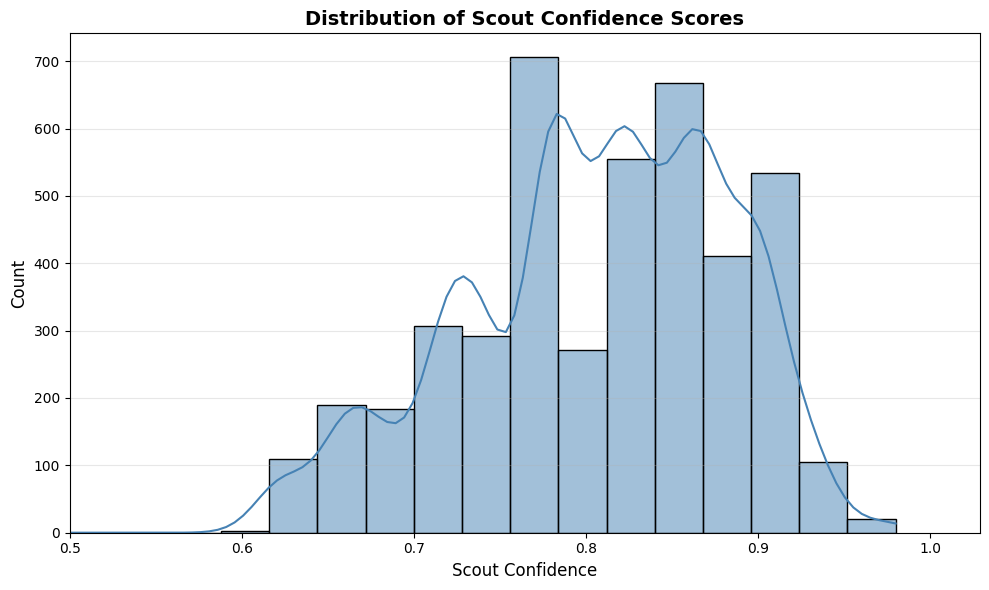

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df['scout_confidence'], bins=35, kde=True, ax=ax, color='steelblue')
ax.set_xlabel('Scout Confidence', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Scout Confidence Scores', fontsize=14, fontweight='bold')
ax.set_xlim(left=0.5)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
df[df['scout_confidence'] <= 0.625].head(3)

,focus_area,provider,url,title,source,published,relevance,date_added,scout_decision,scout_confidence,...,content_loaded_locally,content_load_error,curator_summary,curator_takeaways,curator_tags,applicability_score,novelty_score,priority_score,verdict_reasoning,curated_at
374,arxiv,arxiv,https://arxiv.org/abs/2512.20457v1,When Natural Strategies Meet Fuzziness and Res...,arXiv,2025-12-23,Summary: In formal strategic reasoning for Mul...,2025-12-25,pursue,0.62,...,True,NaN,"This paper introduces HumanATL[F], a formal lo...",\n- This paper is NOT about LLM-based agents o...,"formal-verification, temporal-logic, game-theo...",1.0,4.0,1.0,This paper addresses formal verification of ga...,2025-12-28T19:28:44.540969
470,arxiv,arxiv,https://arxiv.org/abs/2512.20094v1,Jensen-Shannon Divergence Message-Passing for ...,arXiv,2025-12-23,"Summary: In this paper, we investigate how the...",2025-12-25,pursue,0.60,...,True,NaN,This paper introduces Jensen-Shannon Divergenc...,\n- When building graph-based document analysi...,"graph-neural-networks, text-classification, ri...",4.0,5.0,4.0,While the paper presents an interesting approa...,2025-12-28T19:14:35.461297
530,arxiv,arxiv,https://arxiv.org/abs/2512.20029v1,$\text{H}^2$em: Learning Hierarchical Hyperbol...,arXiv,2025-12-23,Summary: Compositional zero-shot learning (CZS...,2025-12-25,pursue,0.62,...,True,NaN,H2EM introduces a framework for Compositional ...,\n- Hyperbolic geometry is better suited than ...,"embeddings, hyperbolic-geometry, zero-shot-lea...",3.0,6.0,4.0,While the hyperbolic embedding approach for hi...,2025-12-28T18:24:22.924849


In [11]:
df[df['scout_decision'] == 'pursue'].iloc[5:10]

,focus_area,provider,url,title,source,published,relevance,date_added,scout_decision,scout_confidence,...,content_loaded_locally,content_load_error,curator_summary,curator_takeaways,curator_tags,applicability_score,novelty_score,priority_score,verdict_reasoning,curated_at
7,reasoning_agent,openai,https://simonwillison.net/2025/Dec/19/agent-sk...,Agent Skills,Simon Willison’s blog,2025-12-19,Technical commentary highlighting implementati...,2025-12-24,pursue,0.82,...,True,NaN,Agent Skills is a newly released open standard...,"\n- Create portable, reusable 'skills' for PE-...","agent-skills, agent-infrastructure, open-stand...",8.0,6.0,7.0,"Agent Skills provides a practical, already-ado...",2025-12-28T18:24:22.616360
8,reasoning_agent,openai,https://arxiv.org/abs/2512.02008,The Art of Scaling Test-Time Compute for Large...,arXiv,2025-12-01,Large-scale empirical comparison of test-time ...,2025-12-24,pursue,0.90,...,True,NaN,This paper presents the first large-scale empi...,\n- Use majority voting with large N (MV@N) fo...,"test-time-scaling, reasoning, inference-optimi...",8.0,5.0,7.0,This paper provides immediately actionable gui...,2025-12-28T18:24:22.617083
9,reasoning_agent,openai,https://arxiv.org/abs/2512.02304,When Does Verification Pay Off? A Closer Look ...,arXiv,2025-12-02,Systematic solver–verifier study (including cr...,2025-12-24,pursue,0.88,...,True,NaN,This paper from NYU's Agentic Learning AI Lab ...,\n- Use different model families for solver an...,"verification, test-time-scaling, rejection-sam...",8.0,7.0,8.0,This paper provides immediately actionable gui...,2025-12-28T18:24:22.617795
10,reasoning_agent,openai,https://arxiv.org/abs/2512.10313,EpiPlanAgent: Agentic Automated Epidemic Respo...,arXiv,2025-12-11 (v2 2025-12-12),Multi-agent LLM workflow for real planning/val...,2025-12-24,pursue,0.80,...,True,NaN,EpiPlanAgent is a multi-agent LLM system desig...,\n- Structured/exact-match RAG outperforms vec...,"multi-agent, RAG, structured-output, document-...",7.0,5.0,6.0,The paper provides a well-validated blueprint ...,2025-12-28T18:24:22.618643
11,reasoning_agent,openai,https://arxiv.org/abs/2512.17912,Graph-O1 : Monte Carlo Tree Search with Reinfo...,arXiv,2025-11-26,Agentic GraphRAG approach combining MCTS + RL ...,2025-12-24,pursue,0.82,...,True,NaN,Graph-O1 proposes an agentic GraphRAG framewor...,\n- Selective graph traversal via MCTS outperf...,"GraphRAG, MCTS, multi-hop-reasoning, reinforce...",6.0,5.0,6.0,While Graph-O1 presents a useful framework com...,2025-12-28T18:24:22.619332


In [12]:
df[df['scout_decision'] == 'discard'].iloc[5:10]

,focus_area,provider,url,title,source,published,relevance,date_added,scout_decision,scout_confidence,...,content_loaded_locally,content_load_error,curator_summary,curator_takeaways,curator_tags,applicability_score,novelty_score,priority_score,verdict_reasoning,curated_at
140,agents_and_finance,anthropic,https://www.weforum.org/stories/2024/12/agenti...,How Agentic AI will transform financial services,World Economic Forum,December 2024,WEF analysis on agentic AI transforming financ...,2025-12-24,discard,0.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,agents_and_finance,anthropic,https://www.v7labs.com/blog/ai-for-private-equ...,5 Applications of AI in Venture Capital and Pr...,V7 Labs,recent,Survey shows 82% of PE/VC firms using AI in Q4...,2025-12-24,discard,0.82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,agents_and_finance,anthropic,https://www.affinity.co/guides/vc-ai-tools,10 AI Tools for Venture Capital Firms in 2025,Affinity,2025,"Guide to AI-powered deal sourcing, relationshi...",2025-12-24,discard,0.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,agents_and_finance,anthropic,https://www.highradius.com/resources/Blog/agen...,How Agentic AI Enhances Financial Reporting: 5...,HighRadius,April 2025,Practical guide on AI agents for journal entry...,2025-12-24,discard,0.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,agents_and_finance,anthropic,https://learn.deeplearning.ai/courses/multi-ai...,Multi AI Agent Systems with CrewAI - Financial...,DeepLearning.AI,May 2024,Educational course on building multi-agent fin...,2025-12-24,discard,0.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
